In [2]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import box

from osgeo import gdal

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.chdir('/users/marianne/documents/pe_snow_fires/')
files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])

<AxesSubplot:>

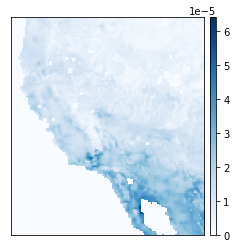

In [4]:
fig,ax=plt.subplots()
pe = rxr.open_rasterio(f,decode_times=False)
ep.plot_bands(pe,ax=ax,cmap='Blues',vmin=0, vmax=np.nanmax(pe.data))


In [5]:
sn_trans = sn.to_crs(pe.rio.crs)
sn_geom = sn.to_crs(pe.rio.crs)

from rasterio.plot import plotting_extent
#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*sn.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
pe_clip = pe.rio.clip(crop_bound_box, crs=sn.crs,
                                    # Include all pixels even partial pixels
                                    all_touched=True,
                                    from_disk=True).squeeze()


pe_ext = plotting_extent(pe_clip,
                            pe_clip.rio.transform())


NameError: name 'sn' is not defined

NameError: name 'pe_clip' is not defined

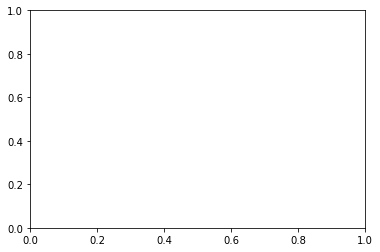

In [5]:
import matplotlib
cols = cm.get_cmap('BrBG', 256)
newcolors = cols(np.linspace(0, 1.5, 256))
white = np.array([1,1,1,0])
newcolors[:1, :] = white
newcmp = matplotlib.colors.ListedColormap(newcolors)

fig,ax=plt.subplots()
# Plotting Bounds Clip
maxval=np.nanmax(pe_clip.values)
pe_clip = pe.rio.clip(sn_geom.geometry,
                    all_touched=True,
                    from_disk=True)
ep.plot_bands(pe_clip,
            ax=ax,
            extent=pe_ext,
            cbar=True, 
            cmap = newcmp,
            title = '2016-09-09',
            vmin=2e-5, vmax=maxval)

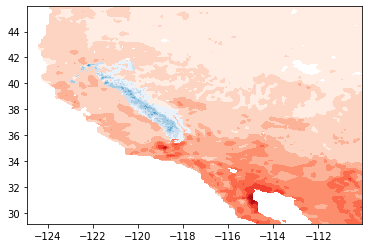

In [98]:
import h5py
from shapely.geometry import Point
os.chdir('/users/marianne/documents/data/reanalysis/')
dailyswe = np.load('daily_swe_avg.npy', allow_pickle=True)
maxday = np.load('max_day.npy', allow_pickle=True)
maxswe = np.load('max_swe.npy', allow_pickle=True)

os.chdir('/users/marianne/documents/data/reanalysis/h5/')
for yr in range(1985 , 1986):
    hf = h5py.File('SN_SWE_WY'+ str(yr) + '.h5', 'r')
    swe = hf.get('SWE')
    day = maxday[yr-1985]
    swe_tmp = swe[day,:,:].astype('float')
    swe_tmp[swe_tmp<0]=np.nan

os.chdir('/users/marianne/documents/pe_snow_fires/')
files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])
pe = rxr.open_rasterio(f,decode_times=False)


lon = [i[0] for i in hf.get('lon').value]
lat = [i for i in hf.get('lat').value[0]]
geometry = [Point(xy) for xy in zip(lon,lat)]

x_, y_ = np.meshgrid(lat, lon)
z_grid = np.array(swe_tmp)# .reshape(len(lat),len(lon))

x,y = np.meshgrid(pe['x'],pe['y'])
z = pe.values[0,:,:]
z[z<0]=np.nan
fig,ax=plt.subplots()
ax.contourf(x,y,z,cmap='Reds')
ax.contourf(y_,x_,z_grid,cmap='Blues')
plt.show()


In [124]:
import re
from osgeo import gdal
os.chdir('/users/marianne/documents/pe_snow_fires/pedata')
files = os.listdir()
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for yr in range(1979,1980):
    y = str(yr)
    for mo in months:
        file_paths = [a for a in files if re.search(r''+y+mo, a)] 
        res = []
        for f in file_paths:
            ds = gdal.Open(r''+f)
            tmp = rxr.open_rasterio(f,decode_times=False)
            tmp = tmp[0,:,:]
            res.append(tmp)
 # We assume that all rasters has a single band
        stacked = np.dstack(res) # We assume that all rasters have the same dimensions
        mean = np.mean(stacked, axis=-1)

        # Finally save a new raster with the result. 
        # This assumes that all inputs have the same geotransform since we just copy the first
        driver = gdal.GetDriverByName('GTiff')
        ofname = 'pe_average_'+y+mo+'.tif'
        result = driver.CreateCopy(ofname, gdal.Open(file_paths[0]))
        result.GetRasterBand(1).WriteArray(mean)
        result = None





In [187]:
import h5py
from shapely.geometry import Point
from osgeo import gdal, osr, ogr
import numpy as np
#create a grid
lats = lat
lons = lon

fpath = '/users/marianne/documents/data/reanalysis/'
dailyswe = np.load(fpath+'daily_swe_avg.npy', allow_pickle=True)
maxday = np.load(fpath + 'max_day.npy', allow_pickle=True)
maxswe = np.load(fpath + 'max_swe.npy', allow_pickle=True)

xres = lons[1] - lons[0]
yres = lats[1] - lats[0]
ysize = len(lats)
xsize = len(lons)
ulx = lons[0] - (xres / 2.)
uly = lats[-1] - (yres / 2.)

fpath = '/users/marianne/documents/data/reanalysis/h5/'
for yr in range(1985, 2017):
    hf = h5py.File(fpath + 'SN_SWE_WY'+ str(yr) + '.h5', 'r')
    swe = hf.get('SWE')
    day = maxday[yr-1985]
    swe_tmp = swe[day,:,:].astype('float')
    swe_tmp[swe_tmp<0]=np.nan


    mag_grid = swe_tmp.transpose()

    driver = gdal.GetDriverByName('GTiff')
    
    ofname = 'swe_max_'+str(yr)+'.tif'
    ds = driver.Create(ofname,
                xsize, ysize, 1, gdal.GDT_Float32, )

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    ds.SetProjection(srs.ExportToWkt())
    gt = [ulx, xres, 0, uly, 0, yres ]
    ds.SetGeoTransform(gt)
    outband=ds.GetRasterBand(1)
    outband.SetStatistics(np.min(mag_grid), np.max(mag_grid), np.average(mag_grid), np.std(mag_grid))
    outband.WriteArray(mag_grid)
    ds = None


OSError: Unable to open file (unable to open file: name = '/users/marianne/documents/data/reanalysis/h5/SN_SWE_WY2016.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [237]:
pe_lat = pe.y
pe_lon = pe.x

In [175]:
#!/usr/bin/env python3                                                                            
import subprocess

os.chdir('c:/users/marianne/documents/pe_snow_fires/')
print(os.getcwd())
# Define command and options wanted
command = "head"
options = "-n 1"
# Ask user for file name(s) - now it's safe from shell injection
filename = 'all_max_pe.npy'
# Create list with arguments for subprocess.run
print(os.listdir())
args=[]
args.append(command)
args.append(options)
for i in filename.split():
    args.append(i)
# Run subprocess.run and save output object
output = subprocess.run(args,capture_output=True)
print('###############')
print('Return code:', output.returncode)
# use decode function to convert to string
print('Output:',output.stdout.decode("utf-8"))

c:\users\marianne\documents\pe_snow_fires
['.DS_Store', '.git', '.gitignore', 'all_max_pe.npy', 'data', 'figures', 'firebounds_sn.gdf', 'ICB', 'pedata', 'README.md', 'reproject.sh', 'scripts', 'swe_test.tif', 'watershed_bounds', 'watershed_masks']


FileNotFoundError: [WinError 2] The system cannot find the file specified

OSError: [WinError 193] %1 is not a valid Win32 application

In [310]:
pe_lat

<xarray.DataArray 'y' (y: 135)>
array([45.9375, 45.8125, 45.6875, 45.5625, 45.4375, 45.3125, 45.1875, 45.0625,
       44.9375, 44.8125, 44.6875, 44.5625, 44.4375, 44.3125, 44.1875, 44.0625,
       43.9375, 43.8125, 43.6875, 43.5625, 43.4375, 43.3125, 43.1875, 43.0625,
       42.9375, 42.8125, 42.6875, 42.5625, 42.4375, 42.3125, 42.1875, 42.0625,
       41.9375, 41.8125, 41.6875, 41.5625, 41.4375, 41.3125, 41.1875, 41.0625,
       40.9375, 40.8125, 40.6875, 40.5625, 40.4375, 40.3125, 40.1875, 40.0625,
       39.9375, 39.8125, 39.6875, 39.5625, 39.4375, 39.3125, 39.1875, 39.0625,
       38.9375, 38.8125, 38.6875, 38.5625, 38.4375, 38.3125, 38.1875, 38.0625,
       37.9375, 37.8125, 37.6875, 37.5625, 37.4375, 37.3125, 37.1875, 37.0625,
       36.9375, 36.8125, 36.6875, 36.5625, 36.4375, 36.3125, 36.1875, 36.0625,
       35.9375, 35.8125, 35.6875, 35.5625, 35.4375, 35.3125, 35.1875, 35.0625,
       34.9375, 34.8125, 34.6875, 34.5625, 34.4375, 34.3125, 34.1875, 34.0625,
       33.9375, 33.8125, 33.6875, 33.5625, 33.4375, 33.3125, 33.1875, 33.0625,
       32.9375, 32.8125, 32.6875, 32.5625, 32.4375, 32.3125, 32.1875, 32.0625,
       31.9375, 31.8125, 31.6875, 31.5625, 31.4375, 31.3125, 31.1875, 31.0625,
       30.9375, 30.8125, 30.6875, 30.5625, 30.4375, 30.3125, 30.1875, 30.0625,
       29.9375, 29.8125, 29.6875, 29.5625, 29.4375, 29.3125, 29.1875])
Coordinates:
  * y            (y) float64 45.94 45.81 45.69 45.56 ... 29.56 29.44 29.31 29.19
    spatial_ref  int32 0

In [321]:
#make geotiff for the pe data
from osgeo import gdal, osr, ogr
import numpy as np
#create a grid
lats = pe_lat
lons = pe_lon

for yr in range(1979, 2016):
    mag_grid = max_pe[str(yr)]

    xres = lons[1] - lons[0]
    yres = lats[1] - lats[0]
    ysize = len(lats)
    xsize = len(lons)
    ulx = lons[0] - (xres / 2.)
    uly = lats[0] - (yres / 2.)


    driver = gdal.GetDriverByName('GTiff')
    ds = driver.Create('pe_'+str(yr)+'.tif',
                xsize, ysize, 1, gdal.GDT_Float32, )
    ##################################
    #pixel type of gdal.GDT_Float32 results in transparent image
    ##################################

    # this assumes the projection is Geographic lat/lon WGS 84
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    ds.SetProjection(srs.ExportToWkt())
    gt = [ulx, xres, 0, uly, 0, yres ]
    ds.SetGeoTransform(gt)
    outband=ds.GetRasterBand(1)
    outband.SetStatistics(np.nanmin(mag_grid).item(), np.nanmax(mag_grid).item(), np.nanmean(mag_grid).item(), np.nanstd(mag_grid).item())
    outband.WriteArray(mag_grid)
    ds = None

<xarray.DataArray 'y' (y: 135)>
array([45.9375, 45.8125, 45.6875, 45.5625, 45.4375, 45.3125, 45.1875, 45.0625,
       44.9375, 44.8125, 44.6875, 44.5625, 44.4375, 44.3125, 44.1875, 44.0625,
       43.9375, 43.8125, 43.6875, 43.5625, 43.4375, 43.3125, 43.1875, 43.0625,
       42.9375, 42.8125, 42.6875, 42.5625, 42.4375, 42.3125, 42.1875, 42.0625,
       41.9375, 41.8125, 41.6875, 41.5625, 41.4375, 41.3125, 41.1875, 41.0625,
       40.9375, 40.8125, 40.6875, 40.5625, 40.4375, 40.3125, 40.1875, 40.0625,
       39.9375, 39.8125, 39.6875, 39.5625, 39.4375, 39.3125, 39.1875, 39.0625,
       38.9375, 38.8125, 38.6875, 38.5625, 38.4375, 38.3125, 38.1875, 38.0625,
       37.9375, 37.8125, 37.6875, 37.5625, 37.4375, 37.3125, 37.1875, 37.0625,
       36.9375, 36.8125, 36.6875, 36.5625, 36.4375, 36.3125, 36.1875, 36.0625,
       35.9375, 35.8125, 35.6875, 35.5625, 35.4375, 35.3125, 35.1875, 35.0625,
       34.9375, 34.8125, 34.6875, 34.5625, 34.4375, 34.3125, 34.1875, 34.0625,
       33.9375, 33.8125, 33.6875, 33.5625, 33.4375, 33.3125, 33.1875, 33.0625,
       32.9375, 32.8125, 32.6875, 32.5625, 32.4375, 32.3125, 32.1875, 32.0625,
       31.9375, 31.8125, 31.6875, 31.5625, 31.4375, 31.3125, 31.1875, 31.0625,
       30.9375, 30.8125, 30.6875, 30.5625, 30.4375, 30.3125, 30.1875, 30.0625,
       29.9375, 29.8125, 29.6875, 29.5625, 29.4375, 29.3125, 29.1875])
Coordinates:
  * y            (y) float64 45.94 45.81 45.69 45.56 ... 29.56 29.44 29.31 29.19
    spatial_ref  int32 0

In [32]:
print(outband.XSize)
print(outband.YSize)
print(mag_grid.shape)

5701
6601
(5701, 6601)


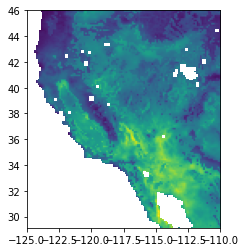

In [322]:
import rasterio
from rasterio.plot import show
fp = r'pe_1979.tif'
img = rasterio.open(fp)
show(img)
img.close()

In [191]:
from osgeo import gdal, osr, ogr
import numpy as np
#create a grid
lats = lat
lons = lon
mag_grid = swe_tmp.transpose()

xres = lons[1] - lons[0]
yres = lats[1] - lats[0]
ysize = len(lats)
xsize = len(lons)
ulx = lons[0] - (xres / 2.)
uly = lats[-1] - (yres / 2.)


driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('swe_test.tif',
               xsize, ysize, 1, gdal.GDT_Float32, )
##################################
#pixel type of gdal.GDT_Float32 results in transparent image
##################################

# this assumes the projection is Geographic lat/lon WGS 84
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
ds.SetProjection(srs.ExportToWkt())
gt = [ulx, xres, 0, uly, 0, yres ]
ds.SetGeoTransform(gt)
outband=ds.GetRasterBand(1)
outband.SetStatistics(np.min(mag_grid), np.max(mag_grid), np.average(mag_grid), np.std(mag_grid))
outband.WriteArray(mag_grid)
ds = None

'c:\\users\\marianne\\documents\\pe_snow_fires'

In [223]:
max_pe={}
os.chdir('./pedata/')
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for yr in range(1979,2016):
    y = str(yr)
    avgs=[]
    for mo in months:
        f = 'pe_monthly_'+y+'_'+mo+'.npy'
        tmp = np.load(f,allow_pickle=True)
        avgs.append(np.nanmean(tmp))
    m_max = np.nanargmax(avgs)
    max_pe[str(yr)] = np.load('pe_monthly_'+y+'_'+months[m_max]+'.npy',allow_pickle=False)
np.save('../all_max_pe.npy',max_pe)
os.chdir('../')

<closed DatasetReader name='swe_rp_1986.tif' mode='r'>

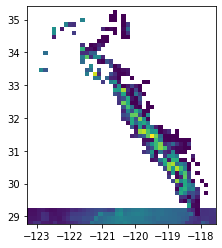

In [309]:
import rasterio
from rasterio.plot import show
f,ax=plt.subplots()
fp = r'pe_1986.tif'
img1 = rasterio.open(fp)
show(img1,ax=ax)
img.close()
fp = r'swe_rp_1986.tif'
img = rasterio.open(fp)
array = img.read(1)
show(img,ax=ax)
img.close()


TypeError: unsupported operand type(s) for /: 'DatasetReader' and 'DatasetReader'

In [343]:
yr=2000
pe_path = 'pe_'+str(yr)+'.tif'
swe_path = 'swe_rp_'+str(yr)+'.tif'
pe_xr = rxr.open_rasterio(pe_path, masked=True).squeeze()
swe_xr = rxr.open_rasterio(swe_path, masked=True).squeeze()

In [284]:
sai = swe_xr/pe_xr

In [290]:
pe_xr.rio.crs

CRS.from_epsg(4326)

In [371]:
# WGS84 coordinates
minx, miny = min(lon), min(lat)
maxx, maxy = max(lon), max(lat)
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=pe_xr.rio.crs)
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords = getFeatures(geo)
sai_all = {}
for yr in range(1985,2016):
    pe_path = 'pe_'+str(yr)+'.tif'
    with rasterio.open(pe_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, coords, crop=True,all_touched=True)
        out_meta = src.meta
    swe_path = 'swe_rp_'+str(yr)+'.tif'
    swe_xr = rxr.open_rasterio(swe_path, masked=True).squeeze()
    sai_all[str(yr)]=  out_image[0,:,:-1] / swe_xr
    

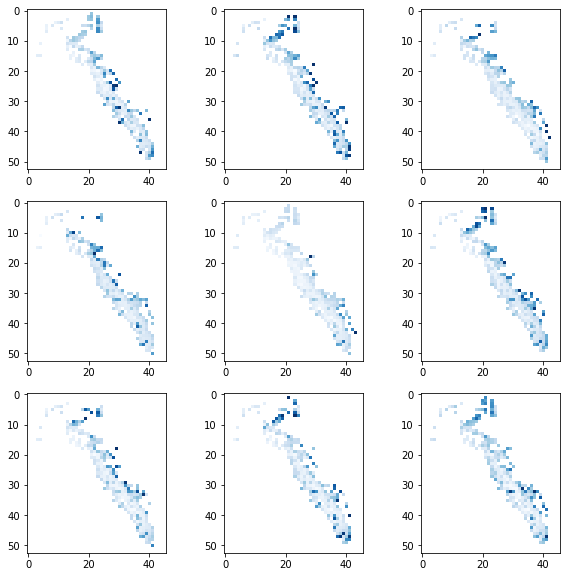

In [390]:
f,axes=plt.subplots(3,3,figsize=(10,10))
years = range(1989,1989+9)
for i, ax in enumerate(axes.flatten()):
    sai = sai_all[str(years[i])]
    ax.imshow(np.log(sai),cmap = 'Blues')

0
1989
1
1990
2
1991
3
1992
4
1993
5
1994
6
1995
7
1996
8
1997
